In [1]:
import json
from itertools import product

import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def jl_to_df(fname):
    with open(fname) as f:
        return pd.DataFrame([json.loads(line) for line in f])
    
def filter_data(df, collection):
    print("Filtering for collection: %s" % collection)
    return df[df['collections'].apply(lambda x: collection in x)]
    
def get_data_matrix(tags, M=None, sparse_output=True):
    """Returns binary matrix"""
    print("Total number of elements: %d" % len(tags))
    if M is None:
        M = len(tags)
    mlb = MultiLabelBinarizer(sparse_output=sparse_output)
    X = mlb.fit_transform(tags[:M])
    print("Total numnber of classes: %d" % len(mlb.classes_))
    return mlb.classes_, X

def get_most_common(labels, X, N=None, min_count=None):
    if N is None:
        N = X.shape[1]
    # Sum columns
    counts = X.sum(axis=0)
    # Squeeze counts into 1 dimensional array
    counts = np.squeeze(np.asarray(counts))
    if min_count is not None:
        N = len([count for count in counts if count >= min_count])        
    # Get indexes of most common popular labels
    idxs = np.argsort(-counts)[:N]
    print("Considering only most popular classes: %d" % len(idxs))
    return labels[idxs], X[:, idxs]

def get_distance_matrix(X):
    # Scipy pdist is much faster than sklearn pairwise_distances
    d = pdist(X, 'jaccard')
    # Return distances as a matrix
    return squareform(d)
    
def get_distance_matrix2(X):
    return pairwise_distances(
        X,
        metric=lambda x,y: 1 - jaccard_similarity_score(x,y)
    )

def get_distance_sparse_matrix(X):
    # It seems that pairwise distances only supports sparse matrices
    # - From scikit-learn: ['cityblock', 'cosine', 'euclidean', 'l1', 'l2',
    # 'manhattan']. These metrics support sparse matrix inputs.

    return pairwise_distances(
        X,
        metric='cosine'
    )

def filter_distances(labels, values, d, maxv=0.95):
    cap_values = np.vectorize(lambda x: 0 if x > maxv else x)
    d = cap_values(d)
    mask = d.sum(axis=0) > 0
    d = d[mask,:][:,mask]
    labels = labels[mask]
    values = values[mask]
    return labels, values, d

def format_nodes(labels, values):
    # TODO: should filer out nodes that have no connection
    return [{"name": label, "value": value} for label, value in zip(labels, values)]

def format_links(d, minv, maxv):
    # It is important to filter the values, otherwise
    # most of them are 1 for labels that have no co-ocurrence
    # or close 1 by chance.
    # TODO: those values should be dynamically inferred.
    idx = product(range(d.shape[0]), range(d.shape[1]))
    return [{"source": i[0], "target": i[1] , "value": v}
            for i, v in zip(idx, d.flatten()) if v > minv and v < maxv]

def save_graph_data(d, labels, values, minv=0, maxv=1, out='data.json'):
    data = {
        "nodes": format_nodes(labels, values),
        "links": format_links(d, minv, maxv)
    }
    with open(out, "w") as f:
        f.write(json.dumps(data))

In [4]:
# Load data
df = jl_to_df("../data/theses_dump_21-03-2017.json")

Total number of elements: 116852
Total numnber of classes: 142546
Considering only most popular classes: 1072


(array([ 781.,  133.,   72.,   26.,   21.,    7.,    8.,    6.,    4.,
           4.,    3.,    0.,    2.,    2.,    1.,    0.,    0.,    0.,
           0.,    2.]),
 array([  100.  ,   269.95,   439.9 ,   609.85,   779.8 ,   949.75,
         1119.7 ,  1289.65,  1459.6 ,  1629.55,  1799.5 ,  1969.45,
         2139.4 ,  2309.35,  2479.3 ,  2649.25,  2819.2 ,  2989.15,
         3159.1 ,  3329.05,  3499.  ]),
 <a list of 20 Patch objects>)

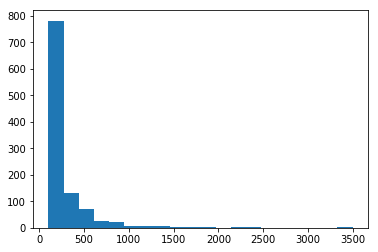

In [15]:
# Get matrix representation
#df = filter_data(df, "col_10024_238")
labels, X = get_data_matrix(df["topics"])
labels, X = get_most_common(labels, X, min_count=100)
X = X.toarray()
values = X.sum(axis=0)
plt.hist(values, bins=20)

In [16]:
# Compute distances
#d = get_distance_matrix(X.T)
d = get_distance_sparse_matrix(X.T)

In [17]:
labels, values, d = filter_distances(labels, values, d, maxv=0.9)

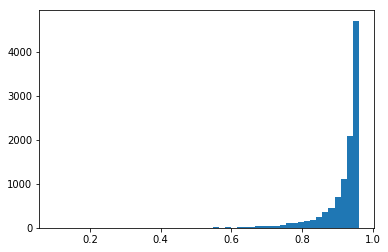

In [8]:
plt.hist(d.flatten(), bins=50, range=(0.1, 0.96))
plt.show()

In [28]:
d.shape

(1057, 1057)

In [29]:
labels.shape

(1057,)

In [30]:
values.shape

(1057,)

In [31]:
if len(values.shape) > 1:
    values = np.squeeze(np.asarray(values))

In [18]:
# Format data for graph
save_graph_data(d, labels, values, minv=0, maxv=0.9, out='force-layout/data.json')

## Degrees topics data

In [16]:
from sklearn.feature_extraction import DictVectorizer

In [51]:
df["degree"] = df["degrees"].apply(lambda x: x[0] if len(x) > 0 else "")
degrees = df.groupby("degree")['topics'].sum()

In [58]:
counts = degrees.apply(lambda x: pd.Series(x).value_counts().to_dict())

In [59]:
labels = degrees.index.values
X = DictVectorizer().fit_transform(counts.values)


In [60]:
labels, X = get_most_common(degrees.index, X.T)

Considering only most popular classes: 667


In [61]:
X.shape

(142546, 667)

In [62]:
X = X.toarray()

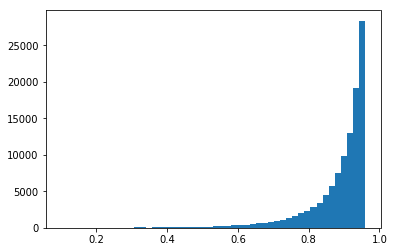

In [63]:
values = X.sum(axis=0)
d = get_distance_sparse_matrix(X.T)
plt.hist(d.flatten(), bins=50, range=(0.1, 0.96))
plt.show()

In [66]:
labels, values, d = filter_distances(labels, values, d, maxv=0.8)
save_graph_data(d, labels, values, minv=0, maxv=0.8, out='force-layout/degrees-data.json')